In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from autogluon.tabular import TabularPredictor, TabularDataset



In [35]:
customers = pd.read_csv('customers_labeled.csv')
customers

,customerID,gender,age_first_order,user_agent_brand,user_agent_os,ip_address_geopoint,ip_address_country,campaign,pages_visited_avg,high_revenue
0,000018,F,59.0,Chrome,Windows,POINT(21.0362 52.2394),Poland,False,12.000000,False
1,000071,F,48.0,Chrome,MacOS X,POINT(139.6895 35.6897),Japan,True,12.666667,False
2,000440,M,44.0,Chrome,Windows,POINT(-2 8),Ghana,True,14.200000,True
3,000452,M,62.0,Chrome,Windows,POINT(139.6895 35.6897),Japan,False,15.000000,False
4,000652,M,20.0,Firefox,Windows,POINT(-97.822 37.751),United States,False,10.000000,False
...,...,...,...,...,...,...,...,...,...,...
10782,zxvu44,F,NaN,Firefox,Windows,POINT(31.2852 30.0778),Egypt,False,9.000000,False
10783,zyvn97,F,47.0,Chrome,Windows,POINT(-97.822 37.751),United States,False,14.500000,False
10784,zzolm4,M,62.0,Chrome,Windows,POINT(-97.822 37.751),United States,False,14.000000,False
10785,zzw4gs,F,61.0,Chrome,Windows,POINT(-97.822 37.751),United States,False,12.000000,False


In [36]:
label = "high_revenue"

In [39]:
X = customers.drop([label], axis=1)
y = customers[label]
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [40]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [41]:
td_train = TabularDataset(train)        

In [47]:
predictor = TabularPredictor(label=label,eval_metric="accuracy").fit(
    train_data=td_train,
    time_limit=60,
    presets="best_quality",
    hyperparameters={
        "GBM": {"extra_trees": True, "ag_args": {"name_suffix":"GBM"}},
        "CAT": {"ag_args": {"name_suffix":"CAT"}},
        "XGB": {"ag_args": {"name_suffix":"XGB"}},
        "RF": {"ag_args": {"name_suffix":"RF"}},
        "NN_TORCH": {"ag_args": {"name_suffix":"NN_TORCH"}},
    }
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250513_132638"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          20
Memory Avail:       4.77 GB / 15.69 GB (30.4%)
Disk Space Avail:   143.84 GB / 471.56 GB (30.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

In [48]:
td_test = TabularDataset(test)

In [49]:
y_pred = predictor.predict(td_test.drop(columns=[label]), as_pandas=True)
y_pred

10562    False
5385     False
9366     False
7300      True
500      False
         ...  
3196     False
1356      True
6295     False
3625      True
2964     False
Name: high_revenue, Length: 398, dtype: bool

In [50]:
y_pred_proba = predictor.predict_proba(td_test, as_pandas=True)
y_pred_proba

,False,True
10562,0.531816,0.468184
5385,0.682432,0.317568
9366,0.676171,0.323829
7300,0.390083,0.609917
500,0.591653,0.408347
...,...,...
3196,0.672999,0.327001
1356,0.357072,0.642928
6295,0.548648,0.451352
3625,0.360746,0.639254


In [51]:
predictor.leaderboard(td_test, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMGBM_BAG_L1,0.708543,0.740554,accuracy,0.064001,0.038196,1.065815,0.064001,0.038196,1.065815,1,True,1
1,LightGBMGBM_BAG_L2,0.708543,0.751259,accuracy,0.338981,0.258155,24.816645,0.140052,0.044235,1.126939,2,True,5
2,WeightedEnsemble_L3,0.706030,0.758186,accuracy,0.313980,0.386027,30.912756,0.000000,0.000000,0.067497,3,True,8
3,CatBoostCAT_BAG_L2,0.703518,0.754408,accuracy,0.216978,0.249092,30.164223,0.018049,0.035171,6.474517,2,True,7
4,WeightedEnsemble_L2,0.698492,0.748111,accuracy,0.033092,0.036234,21.956017,0.000000,0.000000,0.031278,2,True,4
5,CatBoostCAT_BAG_L1,0.698492,0.748111,accuracy,0.033092,0.036234,21.924739,0.033092,0.036234,21.924739,1,True,3
6,RandomForestRF_BAG_L2,0.698492,0.743703,accuracy,0.295931,0.350857,24.370742,0.097002,0.136936,0.681036,2,True,6
7,RandomForestRF_BAG_L1,0.693467,0.706549,accuracy,0.101836,0.139490,0.699152,0.101836,0.139490,0.699152,1,True,2


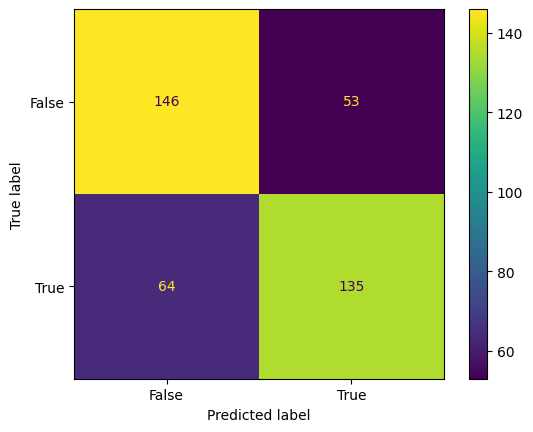

In [52]:
cm = confusion_matrix(td_test[label], y_pred)
ConfusionMatrixDisplay(cm, display_labels=predictor.classes_).plot()